## PySDM

In [1]:
import sys, os
os.environ["NUMBA_DISABLE_JIT"] = "1"

import numpy as np

from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Collision
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity, UniformRandom

from PySDM.products.size_spectral import ParticleVolumeVersusRadiusLogarithmSpectrum, ParticleSizeSpectrumPerVolume
import PySDM.products.size_spectral.arbitrary_moment as am
from PySDM.products.housekeeping.timers import WallTime

from matplotlib import pyplot

from PySDM.initialisation.spectra import Gamma, Exponential
from PySDM.dynamics.collisions.collision_kernels import SimpleGeometric
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.dynamics.collisions.breakup_efficiencies import ConstEb
from PySDM.dynamics.collisions.breakup_fragmentations import AlwaysN
from PySDM.physics.constants import si
from PySDM.physics.constants_defaults import rho_w, rho_STP
from PySDM import Formulae
from pystrict import strict

from numba import config, threading_layer
config.THREADING_LAYER = 'default'

from scipy.stats import gamma

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (idx, array[idx])

In [3]:
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**15
        self.n_part = 10 / si.cm**3
        self.r_scale = 15 * si.um
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 600 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 4*3600.0]
        self.kernel = SimpleGeometric(C=np.pi * 1e-12 * si.cm**3 / si.um**4 / si.s)
        self.coal_eff = ConstEc(Ec=1.0)
        self.fragmentation = AlwaysN(n=1)
        self.break_eff = ConstEb(0.0) # no "bouncing"
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=Formulae().trivia.volume(self.r_scale))
        self.radius_bins_edges = np.logspace(np.log10(1 * si.um), np.log10(1000 * si.um), num=128, endpoint=True)
        self.volume_bins_edges = self.radius_bins_edges**3 * 4 * np.pi / 3
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

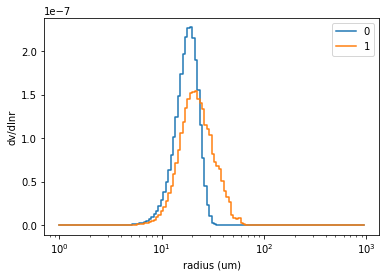

In [4]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
# env['rhod'] = 1
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
products = [dvdlnr, nv]
core = builder.build(attributes, products)
sdm_y = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_y1 = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
i = 0
v_cutoff = 1e3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]
dr = settings.radius_bins_edges[1:] - settings.radius_bins_edges[:-1]
for step in settings.output_steps:
    core.run(step - core.n_steps)
    sdm_y[:,i] = core.products['N(v)'].get() * si.cm**3 * dr
    sdm_y1[:,i] = core.products['dv/dlnr'].get()[0]
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.um, 
            y=sdm_y1[:,i],
            where='post', label="t = {step*settings.dt}s")
    i += 1
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dv/dlnr")
pyplot.legend([0, 1, 2])
#pyplot.xlim([1e1, 1e6])

In [5]:
dlnr = np.mean(np.log(settings.radius_bins_edges[1:]) - np.log(settings.radius_bins_edges[:-1]))

In [6]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd) #UniformRandom(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)

M0 = am.make_arbitrary_moment_product(rank=0, attr='volume', attr_unit='dimensionless')(name='M0')
M1 = am.make_arbitrary_moment_product(rank=1, attr='volume', attr_unit='m^3')(name='M1')
M2 = am.make_arbitrary_moment_product(rank=2, attr='volume', attr_unit='m^6')(name='M2')
Nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
products = [M0, M1, M2, Nv, dvdlnr]
core = builder.build(attributes, products)
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
dx_sdm = np.diff(np.append([0.0], sdm_x))

r_cutoff = 25
v_cutoff = 4/3*np.pi*r_cutoff**3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]

mom0 = np.zeros(int(settings._steps[-1]/settings.dt))
mom1 = np.zeros(int(settings._steps[-1]/settings.dt))
mom2 = np.zeros(int(settings._steps[-1]/settings.dt))
sdm_precip = np.zeros(int(settings._steps[-1]/settings.dt))
i = 0
for step in range(int(settings._steps[-1]/settings.dt)):
    core.run(step - core.n_steps)
    mom0[i] = M0.get()
    mom1[i] = M1.get() 
    mom2[i] = M2.get()
    dvdlnr_instant = core.products['dv/dlnr'].get()[0] * si.cm**3 / si.um**3
    mv_instant = dvdlnr_instant*dlnr

    sdm_precip[i] = np.sum(mv_instant[bin_cutoff:])
    i += 1
times_sdm = range(0,int(settings._steps[-1]),int(settings.dt))


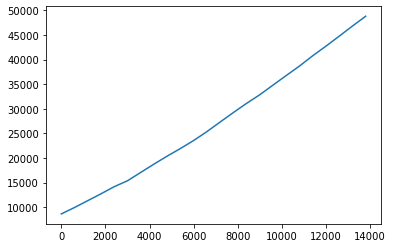

In [7]:
pyplot.plot(times_sdm, sdm_precip)

## Bin

In [8]:
# geometric_IC2
# Tmax, nbin, dt, scal, emin, rhow, A, k1, theta, N0 
# [7200, 32, 1.0, 1, 7.091336e-10, 1e-09, 0.0001, 1.0, 14137.166941154068, 10.0]

v_grid = [1.06370040e+00, 2.12740080e+00, 4.25480160e+00, 8.50960320e+00,
 1.70192064e+01, 3.40384128e+01, 6.80768256e+01, 1.36153651e+02,
 2.72307302e+02, 5.44614605e+02, 1.08922921e+03, 2.17845842e+03,
 4.35691684e+03, 8.71383368e+03, 1.74276674e+04, 3.48553347e+04,
 6.97106694e+04, 1.39421339e+05, 2.78842678e+05, 5.57685355e+05,
 1.11537071e+06, 2.23074142e+06, 4.46148284e+06, 8.92296569e+06,
 1.78459314e+07, 3.56918627e+07, 7.13837255e+07, 1.42767451e+08,
 2.85534902e+08, 5.71069804e+08, 1.14213961e+09, 2.28427922e+09]
r_grid = [6.33252487e-01, 7.97848139e-01, 1.00522566e+00, 1.26650497e+00,
 1.59569628e+00, 2.01045133e+00, 2.53300995e+00, 3.19139256e+00,
 4.02090266e+00, 5.06601990e+00, 6.38278511e+00, 8.04180532e+00,
 1.01320398e+01, 1.27655702e+01, 1.60836106e+01, 2.02640796e+01,
 2.55311404e+01, 3.21672213e+01, 4.05281592e+01, 5.10622809e+01,
 6.43344425e+01, 8.10563184e+01, 1.02124562e+02, 1.28668885e+02,
 1.62112637e+02, 2.04249124e+02, 2.57337770e+02, 3.24225274e+02,
 4.08498247e+02, 5.14675540e+02, 6.48450547e+02, 8.16996494e+02]

gr0 = [2.40084895e-003, 9.60267324e-003, 3.84049132e-002, 1.53573426e-001,
 6.13924051e-001, 2.45274166e+000, 9.78737296e+000, 3.89614226e+001,
 1.54351960e+002, 6.05629257e+002, 2.33096767e+003, 8.63246975e+003,
 2.95987046e+004, 8.69937376e+004, 1.87870491e+005, 2.19048227e+005,
 7.44461241e+004, 2.14974427e+003, 4.48142597e-001, 4.86872324e-009,
 1.43665609e-025, 3.12729096e-059, 3.70458223e-127, 1.29963425e-263,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]
gr18 = [2.27997513e-003, 9.11227838e-003, 3.64052756e-002, 1.45385460e-001,
 5.80236779e-001, 2.31343416e+000, 9.20844470e+000, 3.65468537e+001,
 1.44281973e+002, 5.63979608e+002, 2.16302128e+003, 7.99404850e+003,
 2.74501105e+004, 8.12536821e+004, 1.77976511e+005, 2.16140881e+005,
 8.95593000e+004, 8.30739985e+003, 2.77288659e+002, 3.54766737e+000,
 2.13274276e-002, 7.60989304e-005, 1.55553893e-009, 6.42285340e-323,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]
gr72 = [1.93656892e-03, 7.72214584e-03, 3.07540559e-02, 1.22331696e-01,
 4.85820681e-01, 1.92514343e+00, 7.60533239e+00, 2.99108614e+01,
 1.16833201e+02, 4.51361463e+02, 1.71156921e+03, 6.27741437e+03,
 2.15962151e+04, 6.50826890e+04, 1.48162577e+05, 1.98973750e+05,
 1.22589416e+05, 3.84346270e+04, 7.49724994e+03, 8.80978524e+02,
 6.46318942e+01, 3.36176575e+00, 1.44893252e-01, 5.13139490e-03,
 8.61300536e-09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
t_bott = [   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800., 1900.,
 2000., 2100., 2200., 2300., 2400., 2500., 2600., 2700., 2800., 2900.,
 3000., 3100., 3200., 3300., 3400., 3500., 3600., 3700., 3800., 3900.,
 4000., 4100., 4200., 4300., 4400., 4500., 4600., 4700., 4800., 4900.,
 5000., 5100., 5200., 5300., 5400., 5500., 5600., 5700., 5800., 5900.,
 6000., 6100., 6200., 6300., 6400., 6500., 6600., 6700., 6800., 6900.,
 7000., 7100., 7200.]
M0_bott = [9.9993864 , 9.97185027, 9.94432756, 9.91681859, 9.88932356, 9.86184262,
 9.8343759 , 9.80692348, 9.77948544, 9.75206186, 9.72465276, 9.69725819,
 9.66987819, 9.64251276, 9.61516193, 9.5878257 , 9.56050407, 9.53319704,
 9.5059046 , 9.47862675, 9.45136346, 9.42411472, 9.3968805 , 9.36966079,
 9.34245556, 9.31526477, 9.2880884 , 9.26092641, 9.23377876, 9.20664543,
 9.17952637, 9.15242154, 9.12533091, 9.09825441, 9.07119202, 9.04414369,
 9.01710936, 8.99008899, 8.96308253, 8.93608993, 8.90911114, 8.8821461 ,
 8.85519476, 8.82825706, 8.80133295, 8.77442238, 8.74752527, 8.72064159,
 8.69377126, 8.66691422, 8.64007041, 8.61323978, 8.58642226, 8.55961777,
 8.53282627, 8.50604769, 8.47928195, 8.45252899, 8.42578874, 8.39906114,
 8.37234611, 8.34564359, 8.3189535 , 8.29227577, 8.26561033, 8.23895711,
 8.21231604, 8.18568703, 8.15907001, 8.13246491, 8.10587165, 8.07929015,
 8.05272033]
M1_bott = [141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246858,
 141374.97246858, 141374.97246859, 141374.97246858, 141374.97246858,
 141374.97246858, 141374.97246858, 141374.97246858, 141374.97246858,
 141374.97246858, 141374.97246858, 141374.97246858, 141374.97246858,
 141374.97246857, 141374.97246857, 141374.97246856, 141374.97246855,
 141374.97246855, 141374.97246855, 141374.97246855, 141374.97246855,
 141374.97246855, 141374.97246855, 141374.97246855, 141374.97246855,
 141374.97246855, 141374.97246855, 141374.97246855, 141374.97246855,
 141374.97246854, 141374.97246854, 141374.97246854, 141374.97246854,
 141374.97246853, 141374.97246852, 141374.97246851, 141374.9724685 ,
 141374.97246849, 141374.97246847, 141374.97246844, 141374.97246843,
 141374.97246844, 141374.97246844, 141374.97246843, 141374.97246843,
 141374.97246843, 141374.97246843, 141374.97246843, 141374.97246843,
 141374.97246843, 141374.97246843, 141374.97246843, 141374.97246843,
 141374.97246842, 141374.97246842, 141374.97246841, 141374.97246841,
 141374.9724684 , 141374.97246839, 141374.97246837, 141374.97246835,
 141374.97246833, 141374.9724683 , 141374.97246827, 141374.97246823,
 141374.97246818]
M2_bott = [3.99886046e+09, 4.01810070e+09, 4.03757784e+09, 4.05728719e+09,
 4.07722785e+09, 4.09740018e+09, 4.11780521e+09, 4.13844441e+09,
 4.15931956e+09, 4.18043274e+09, 4.20178622e+09, 4.22338249e+09,
 4.24522419e+09, 4.26731415e+09, 4.28965530e+09, 4.31225077e+09,
 4.33510376e+09, 4.35821763e+09, 4.38159586e+09, 4.40524205e+09,
 4.42915990e+09, 4.45335324e+09, 4.47782602e+09, 4.50258230e+09,
 4.52762623e+09, 4.55296211e+09, 4.57859434e+09, 4.60452742e+09,
 4.63076599e+09, 4.65731480e+09, 4.68417871e+09, 4.71136271e+09,
 4.73887192e+09, 4.76671157e+09, 4.79488702e+09, 4.82340377e+09,
 4.85226744e+09, 4.88148378e+09, 4.91105870e+09, 4.94099824e+09,
 4.97130857e+09, 5.00199603e+09, 5.03306708e+09, 5.06452838e+09,
 5.09638670e+09, 5.12864900e+09, 5.16132240e+09, 5.19441419e+09,
 5.22793183e+09, 5.26188297e+09, 5.29627543e+09, 5.33111722e+09,
 5.36641657e+09, 5.40218187e+09, 5.43842174e+09, 5.47514500e+09,
 5.51236070e+09, 5.55007810e+09, 5.58830669e+09, 5.62705620e+09,
 5.66633659e+09, 5.70615809e+09, 5.74653118e+09, 5.78746659e+09,
 5.82897534e+09, 5.87106871e+09, 5.91375830e+09, 5.95705598e+09,
 6.00097394e+09, 6.04552468e+09, 6.09072103e+09, 6.13657615e+09,
 6.18310357e+09]
mprecip_bin = [  496.79993706,   559.91429801,   625.39858343,   693.22737969,
   763.38050339,   835.84172345,   910.59792483,   987.63849856,
  1066.95487718,  1148.54017188,  1232.38888379,  1318.49667092,
  1406.86015773,  1497.47677797,  1590.34464372,  1685.46243555,
  1782.82930955,  1882.44481828,  1984.30884315,  2088.42153626,
  2194.78327012,  2303.39459412,  2414.25619652,  2527.36887132,
  2642.73348927,  2760.35097227,  2880.22227096,  3002.34834495,
  3126.73014524,  3253.36859881,  3382.26459487,  3513.41897272,
  3646.83251101,  3782.50591817,  3920.43982397,  4060.63477202,
  4203.09121319,  4347.80949971,  4494.7898801 ,  4644.0324946 ,
  4795.53737125,  4949.30442244,  5105.33344198,  5263.6241025 ,
  5424.17595331,  5586.98841859,  5752.06079585,  5919.39225479,
  6088.98183628,  6260.82845168,  6434.93088236,  6611.28777943,
  6789.89766364,  6970.75892542,  7153.86982517,  7339.2284936 ,
  7526.83293226,  7716.68101415,  7908.77048446,  8103.09896146,
  8299.66393739,  8498.4627795 ,  8699.49273118,  8902.75091313,
  9108.23432457,  9315.93984461,  9525.86423358,  9738.00413446,
  9952.35607432, 10168.91646588, 10387.68160899, 10608.64769226,
 10831.81079468]


In [9]:
gr_0 = np.array(gr0)
gr_f = np.array(gr72) # um**3/cm3
r_grid = np.array(r_grid)
r_grid = np.insert(r_grid, 0, 0.0)

In [10]:
v_grid_plt = np.array(v_grid)*np.sqrt(2)
r_grid_plt = (v_grid_plt / 4 / np.pi * 3)**(1/3)

## Cloudy

In [11]:
# import rbf from julia setup
from scipy.stats import norm
from scipy.stats import gamma

def cslogrbf1(x, mean, stddev):
    r = abs((np.log(x)-mean)/stddev)
    cslogr = np.zeros(len(x))
    for (i, ri) in enumerate(r):
        if (ri < 1):
            cslogr[i] = 12/35*(1-ri)**4 * (4+16*ri+12*ri**2+3*ri**3)/x[i]/stddev
    return cslogr

def rbf_basis(x, constants, means, stddev):
    N = len(means)
    assert (len(stddev) == N)
    assert (len(constants) == N)
    pdf_result = 0
    
    for i in range(N):
        pdf_result += constants[i]*cslogrbf1(x, means[i], stddev[i])
        
    return pdf_result

def rbf8_i(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_init = [0.011319209813756295, 5.007971833138832e-6, 2.167500100814402, 5.8877621048338495, 0.0, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_init, means, stddevs)

def rbf8_f(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_final = [0.0, 0.02075777025819778, 1.0349867866402922, 2.5072133292824414, 0.3557005531919539, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_final, means, stddevs)

def rbf16_i(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [4.432887537178635, 4.432887537178635, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236]
    c_init = [9.705174773414926e-7, 0.12057762502197195, 0.09446231101681898, 0.275606184504158, 0.6998802079551418, 1.5890963874552382, 3.1355930770990152, 3.6885910551117798, 0.2395261260779029, 8.071150668242785e-8, 2.621979216442597e-8, 1.3915775033823228e-8, 1.1191120200057128e-8, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_init, means, stddevs)

def rbf16_f(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [4.432887537178635, 4.432887537178635, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236]
    c_final = [0.002047274973603533, 0.07356107211722715, 0.05673185355532061, 0.1593248998741649, 0.3915769100979307, 0.8509074447403923, 1.745798142583672, 2.238660246786771, 0.5671840963689417, 0.12918421865327387, 0.016228025107245143, 0.0, 0.0, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_final, means, stddevs)
    
# EXP CASE
# initial N, k, theta = 10.0, 1.0, 14137.166941154068, 
# final N, k, theta = 10.000986008631083, 1.0, 14135.773141721591,
def mom_f(x):
    n = 10.000986008631083
    k = 1.0
    theta = 14135.773141721591
    return n*gamma.pdf(x, k, scale=theta)
def mom_i(x):
    n =10.0
    k =1.0
    theta = 14137.166941154068
    return n*gamma.pdf(x, k, scale=theta)
    

In [12]:
col_8_times = [0.0, 0.8005751074860143, 7.216198632592491, 71.37243388365725, 712.9347863943048, 1059.2766013221424, 1465.7319883809564, 3797.7036745257037, 6822.230559849885, 9986.463510719588, 14400.0]
col_8_M_0 = [8.0609262822703, 8.060692625073361, 8.058820160145682, 8.040026552505847, 7.845775689124377, 7.736677992003212, 7.605778902092042, 6.8224393811362685, 5.829488698237485, 4.919994490736225, 3.916436569751766]
col_8_M_1 = [141371.88186888164, 141375.94768254497, 141408.66844862385, 141732.06248035654, 144610.14814050938, 145852.65086846313, 147098.28644059072, 149827.42382908403, 145188.4649274314, 135240.5386427758, 119046.6633857112]
col_8_M_2 = [8.551692480400762e9, 8.555558872198236e9, 8.586615320895086e9, 8.895855206930658e9, 1.2616152579459114e10, 1.334606539546217e10, 1.5003877304745607e10, 2.258569593412365e10, 2.81625086231012e10, 3.0401667062194168e10, 3.021507086253773e10]

col_16_times = [0.0, 0.698058530669551, 4.813899363807165, 20.621819667651973, 45.2396349194098, 91.82569890442271, 138.36836384652122, 160.26128817634623, 379.19053147459636, 1458.7237625266594, 2289.0629897743793, 4371.485997744059, 6483.986479605359, 8109.993560618781, 9468.442726601803, 10918.598738254106, 12842.204234383265, 14400.0]
col_16_M_0 = [9.814608425077534, 9.814423350440823, 9.813332523665164, 9.80914297875094, 9.802618782223014, 9.790273290908699, 9.77792887775865, 9.772128114919145, 9.714139168123001, 9.4297680326399, 9.213309683704338, 8.675407655906914, 8.136530558890644, 7.728267097233819, 7.393348424750938, 7.042779180592835, 6.581377385248641, 6.212656118245525]
col_16_M_1 = [141371.06401646842, 141370.8241514956, 141369.5565063392, 141364.62655038128, 141356.86754157083, 141341.6319331089, 141325.6519866568, 141317.99429354933, 141233.96092961467, 140772.18097721285, 140552.22144112946, 140072.4191782949, 139336.5881457825, 138426.0572452212, 137382.0854186691, 136962.80290083433, 136289.76200885593, 135371.8374215193]
col_16_M_2 = [4.35033827315877e9, 4.35041960542552e9, 4.351250342350894e9, 4.354282673416754e9, 4.359540628946397e9, 4.368522101660951e9, 4.378197802078203e9, 4.382574202901312e9, 4.425696803573037e9, 4.638136158258349e9, 4.862964177453565e9, 5.550790748894875e9, 6.336305458316986e9, 6.956230681922522e9, 7.450221324101589e9, 8.5034471478104105e9, 1.019540634975085e10, 1.1623557340249352e10]


In [13]:
# EXP CASE
t_cloudy = [0.0, 0.46911342242468324, 5.160247646671515, 52.07158988913983, 521.1850123138229, 5212.319236560654, 14400.0]
M0_cloudy = [10.0, 10.000000032121532, 10.00000035333685, 10.000003565490012, 10.000035687021203, 10.000356902290173, 10.000986008631083]
M1_cloudy = [141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067]
M2_cloudy = [3.997189782441189e9, 3.997189769601603e9, 3.9971896412057495e9, 3.9971883572476726e9, 3.9971755177124434e9, 3.997047126913836e9, 3.996795694936001e9]
t_precip_mom = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_mom = [7766.397392679327, 7766.367943229873, 7766.338493887113, 7766.3090446510205, 7766.279595521621, 7766.25014649889, 7766.220697582852, 7766.191248773487, 7766.1618000708, 7766.132351474801, 7766.102902985471, 7766.073454602821, 7766.04400632685, 7766.014558157558, 7765.98511009494, 7765.955662139, 7765.926214289735, 7765.896766547151, 7765.8673189112415, 7765.837871382, 7765.808423959445, 7765.778976643556, 7765.749529434346, 7765.720082331808, 7765.690635335946, 7765.661188446754, 7765.631741664231, 7765.60229498839, 7765.572848419215, 7765.543401956712, 7765.513955600881, 7765.484509351719, 7765.455063209235, 7765.425617173414, 7765.396171244267, 7765.366725421791, 7765.337279705976, 7765.307834096838, 7765.278388594366, 7765.248943198559, 7765.21949790943, 7765.190052726955, 7765.160607651158, 7765.131162682026, 7765.101717819555, 7765.072273063756, 7765.042828414619, 7765.01338387215, 7764.983939436346, 7764.954495107201, 7764.925050884722, 7764.895606768913, 7764.8661627597585, 7764.836718857276, 7764.807275061455, 7764.777831372287, 7764.748387789798, 7764.718944313956, 7764.689500944777, 7764.660057682264, 7764.63061452641, 7764.601171477219, 7764.571728534688, 7764.542285698809, 7764.512842969596, 7764.483400347044, 7764.45395783115, 7764.424515421905, 7764.395073119327, 7764.365630923403, 7764.336188834136, 7764.306746851524, 7764.277304975574, 7764.247863206273, 7764.218421543637, 7764.188979987646, 7764.159538538317, 7764.130097195635, 7764.100655959617, 7764.071214830248, 7764.041773807536, 7764.012332891475, 7763.982892082067, 7763.953451379306, 7763.924010783203, 7763.894570293746, 7763.86512991095, 7763.835689634796, 7763.806249465301, 7763.7768094024495, 7763.74736944625, 7763.717929596698, 7763.6884898537955, 7763.659050217547, 7763.629610687943, 7763.600171264991, 7763.570731948684, 7763.541292739022, 7763.5118536360105, 7763.482414639643]


In [14]:
t_precip_8 = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_8 = [46094.25145425666, 47314.09048439214, 48506.71656864892, 49672.20066975443, 50863.72196959075, 51920.74519560104, 53003.14504646637, 54058.553054002245, 55086.721771399694, 56087.52260569809, 57061.06155352677, 58007.445992151006, 58926.81910895556, 59819.371701961725, 60685.309814678214, 61524.85460180607, 62338.24232923904, 63125.72437406324, 63887.567224557344, 64624.05248019252, 65335.47685163249, 66022.15216073346, 66684.40534054412, 67322.57843530572, 67937.02860045199, 68528.12810260913, 69096.26431959594, 69641.80694486451, 70165.12017951795, 70666.61822835988, 71146.89177738159, 71606.67197007927, 72045.85798371502, 72464.86098057652, 72864.09100215921, 73243.95696916615, 73604.86668150795, 73947.22681830294, 74271.442937877, 74577.91947776367, 74867.05975470415, 75139.26596464725, 75394.93918274944, 75634.47936337475, 75858.28534009488, 76066.75482568926, 76260.28441214474, 76439.26941421728, 76604.08211667268, 76755.08927501422, 76892.66365154306, 77017.17192437666, 77128.97468744875, 77228.42645050932, 77315.87563912467, 77391.66459467742, 77456.12957436632, 77509.60075120647, 77552.40221402925, 77584.8519674823, 77607.26193202959, 77619.93794395123, 77623.1797553437, 77617.2810341198, 77602.52936400846, 77579.206244555, 77547.587091121, 77507.94123488417, 77460.53192283868, 77405.61767558499, 77343.46397014793, 77274.31419216986, 77198.4014348817, 77115.95408707592, 77027.19583310607, 76932.34565288722, 76831.61782189569, 76725.22191116914, 76613.36278730656, 76496.24061246827, 76374.05084437593, 76246.98423631254, 76115.22683712229, 75978.95999121098, 75838.36033854554, 75693.59981465424, 75544.84565062671, 75392.26037311395, 75236.00180432826, 75076.22306204321, 74913.07255959386, 74746.69400587636, 74577.22640534844, 74404.80405802901, 74229.55655949835, 74051.608800898, 73871.08096893103, 73688.08854586165, 73502.7423095154, 73315.14833327926]
t_precip_16 = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_16 = [11547.595626181239, 11827.109728949272, 12102.78874520236, 12374.608461100855, 12642.522525231821, 12906.690770724075, 13167.045984372115, 13438.066425989493, 13719.041680793933, 14016.629091986955, 14319.1418068342, 14626.297787960852, 14937.886911661239, 15253.68069112345, 15573.454650736572, 15896.988358939529, 16224.065409887105, 16554.47316197673, 16888.003303893915, 17224.45149383513, 17563.617179524153, 17905.30359821209, 18249.317776677475, 18595.47053122605, 18943.576467691044, 19293.45398143296, 19644.925257339717, 19997.81626982647, 20351.956782835776, 20707.1803498376, 21063.324313829202, 21420.229276904513, 21777.739398736736, 22135.702969296883, 22493.97172833611, 22852.400863660852, 23210.849011132716, 23569.17825466855, 23927.254126240383, 24284.945605875502, 24642.125121656423, 24998.668549720824, 25354.45521426162, 25709.367887526965, 26063.29278982021, 26416.118719374248, 26767.733141436936, 27118.03470172678, 27466.925848388484, 27814.310900324086, 28160.31234697959, 28505.120010272458, 28848.333145477358, 29189.735566488405, 29529.049932802845, 29865.937749521327, 30200.009293458745, 30531.311389982526, 30860.3466556168, 31187.450628536055, 31512.778440526046, 31836.3048169839, 32157.824076918027, 32476.950132948128, 32793.116491305176, 33105.57625183144, 33414.84905328428, 33776.3683238558, 34191.870858834154, 34607.84642019996, 35023.94974442149, 35439.89788445292, 35855.47020973443, 36270.508406192166, 36684.91647623823, 37098.66073877071, 37511.66997083968, 37923.75982902094, 38334.803919084596, 38744.67765727048, 39153.257928012754, 39560.42308394004, 39966.05294587536, 40370.02880283608, 40772.23341203401, 41172.55099887539, 41570.8672569608, 41967.06934808528, 42361.04590223821, 42752.687630057866, 43141.88845874738, 43528.54338139864, 43912.549670807835, 44293.80696956696, 44672.21729006358, 45047.68501448099, 45420.116894798164, 45789.42205278981, 46155.51198002623, 46518.30053787345]


## Plotting

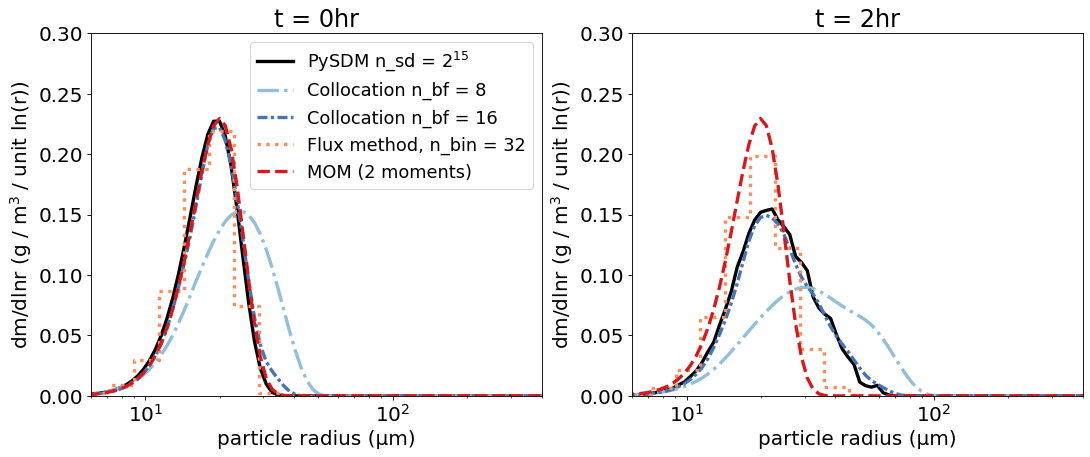

In [15]:
# plot all of them
pyplot.rcParams.update({'font.size':18})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(16,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM sdm_y1: m^3 / m^3 / (unit ln R) --> 1e6 g / m^3 / unit ln R
r_sdm = settings.radius_bins_edges[1:] / si.um
dlnr_sdm = np.log(r_sdm[2]) - np.log(r_sdm[1])

ax[0].plot(r_sdm, sdm_y1[:,0] * 1e6, linestyle=ls[0], color=colors[0], label='PySDM n_sd = $2^{15}$', linewidth=3)
ax[1].plot(r_sdm, sdm_y1[:,-1] * 1e6, linestyle=ls[0], color=colors[0], label='PySDM n_sd = $2^{15}$', linewidth=3)


# COLLOCATION: (um^6 / cm^3) -> 
x = settings.volume_bins_edges[:-1]/si.um**3
yrbf8i = rbf8_i(x)
yrbf8f = rbf8_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf8i * si.cm**3, linestyle=ls[1],color=colors[1], label='Collocation n_bf = 8',linewidth=3)#, label='Collocation n_bf = 8, init')
ax[1].plot(r_sdm, 3*x*x*yrbf8f * si.cm**3, linestyle=ls[1],color=colors[1], label='Collocation n_bf = 8',linewidth=3)
yrbf16i = rbf16_i(x)
yrbf16f = rbf16_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf16i * si.cm**3, linestyle=ls[2],color=colors[2], label='Collocation n_bf = 16',linewidth=3)#, label='Collocation n_bf = 16, init')
ax[1].plot(r_sdm, 3*x*x*yrbf16f * si.cm**3, linestyle=ls[2],color=colors[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].step(r_grid_plt,
            gr_0 * si.cm**3,
            linestyle=ls[3],color=colors[3],label='Flux method, n_bin = 32', linewidth=3)#, label='Flux method, n_bin = 32, init')
ax[1].step(r_grid_plt,  
            gr_f * si.cm**3,
            linestyle=ls[3],color=colors[3], label='Flux method, n_bin = 32',linewidth=3)


# BULK: (um^3 / cm^3) / (um^3)
ymomi = mom_i(x)
ymomf = mom_f(x)
ax[0].plot(r_sdm, 3*x*x*ymomi * si.cm**3, linestyle=ls[4],color=colors[4],label="MOM (2 moments)",linewidth=3)#, label="MOM (3 moments), init")
ax[1].plot(r_sdm, 3*x*x*ymomf * si.cm**3, linestyle=ls[4],color=colors[4], label="MOM (2 moments)",linewidth=3)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel("particle radius (µm)")
#ax[0].set_ylabel("volume density µm$^3$/cm$^3$ per um$^3$")
ax[0].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[1].set_xlabel("particle radius (µm)")
ax[1].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[0].set_xlim([6.0, 400.0])
ax[1].set_xlim([6.0, 400.0])
ax[0].set_ylim([0.0, 0.3])
ax[1].set_ylim([0.0, 0.3])
ax[0].legend(fontsize=16)

ax[0].set_title('t = 0hr')
ax[1].set_title('t = 2hr')

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')

#ax[0].grid()
#ax[1].grid()

#pyplot.savefig("m(v)_geometric_IC2.pdf", transparent=True)

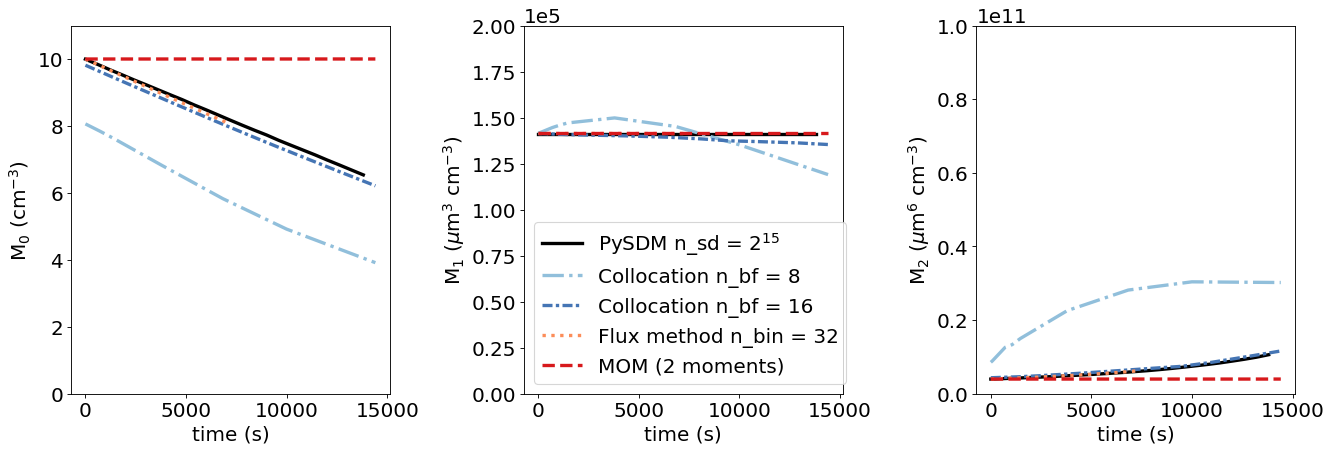

In [16]:
# plot all of them
from matplotlib.ticker import ScalarFormatter
xfmt = ScalarFormatter()
xfmt.set_powerlimits((-3,3))  # Or whatever your limits are . . .

fig, ax = pyplot.subplots(nrows=1, ncols=3, figsize=(17,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM:
ax[0].plot(times_sdm, mom0*si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
ax[1].plot(times_sdm, mom1 / si.um**3 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)
ax[2].plot(times_sdm, mom2 / si.um**6 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)

# COLLOCATION:
ax[0].plot(col_8_times, col_8_M_0, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[1].plot(col_8_times, col_8_M_1, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[2].plot(col_8_times, col_8_M_2, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)

ax[0].plot(col_16_times, col_16_M_0, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[1].plot(col_16_times, col_16_M_1, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[2].plot(col_16_times, col_16_M_2, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].plot(t_bott, M0_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[1].plot(t_bott, M1_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[2].plot(t_bott, M2_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)

# # BULK: (um^3 / cm^3) / (um^3)
ax[0].plot(t_cloudy, M0_cloudy, color=colors[4],linestyle=ls[4], label='MOM (2 moments)',linewidth=3)
ax[1].plot(t_cloudy, M1_cloudy, color=colors[4],linestyle=ls[4], label='MOM (2 moments)',linewidth=3)
ax[2].plot(t_cloudy, M2_cloudy, color=colors[4],linestyle=ls[4], label='MOM (2 moments)',linewidth=3)

ax[0].set_xlabel('time (s)')
ax[1].set_xlabel('time (s)')
ax[2].set_xlabel('time (s)')
ax[0].set_ylabel('M$_0$ (cm$^{-3}$)')
ax[1].set_ylabel('M$_1$ ($\mu$m$^3$ cm$^{-3}$)')
ax[2].set_ylabel('M$_2$ ($\mu$m$^6$ cm$^{-3}$)')
ax[0].set_ylim([0, 11])
ax[1].set_ylim([0, 2e5])
ax[2].set_ylim([0, 1e11])
ax[1].legend()
ax[1].yaxis.set_major_formatter(xfmt)

pyplot.tight_layout()
#pyplot.savefig("moments_geometric_IC2.pdf", transparent=True)


In [17]:
volume_cutoff = 4/3*np.pi*r_cutoff**3

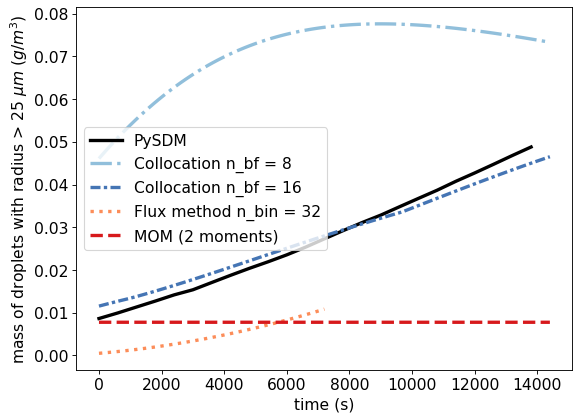

In [18]:
# plot all of them
pyplot.rcParams.update({'font.size':14})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

pyplot.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(times_sdm, sdm_precip[:] / 1e6, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
pyplot.plot(t_precip_8, np.divide(m_precip_8, 1e6), color=colors[1], linestyle=ls[1],label='Collocation n_bf = 8',linewidth=3)
pyplot.plot(t_precip_16, np.divide(m_precip_16, 1e6), color=colors[2], linestyle=ls[2],label='Collocation n_bf = 16',linewidth=3)
pyplot.plot(t_bott, np.divide(mprecip_bin, 1e6), color=colors[3], linestyle=ls[3],label='Flux method n_bin = 32',linewidth=3)
pyplot.plot(t_precip_mom, np.divide(m_precip_mom, 1e6), color=colors[4], linestyle=ls[4],label='MOM (2 moments)',linewidth=3)
pyplot.xlabel('time (s)')
pyplot.ylabel('mass of droplets with radius > 25 $\mu m$ $(g / m^3)$')
pyplot.legend()
pyplot.gca().yaxis.set_major_formatter(xfmt)
pyplot.savefig('m_precip_geometric_IC2.pdf', transparent=True)

## Error Computation

In [20]:
import pickle

def compute_L2_error(y1, y2):
    return np.linalg.norm(y1-y2)/np.linalg.norm(y2)

def bott_m_f(x):
    mf = np.zeros(len(x))
    dlnr_bin = np.mean(np.log(r_grid[2:]) - np.log(r_grid[1:-1]))
    for i in range(len(x)):
        i0 = find_nearest(v_grid,x[i])[0]
        mf[i] = gr_f[i0]#/dlnr_bin*dlnr
    return mf

v_sdm = x

yrbf8f = rbf8_f(v_sdm)
e8f = compute_L2_error(3*yrbf8f*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

yrbf16f = rbf16_f(v_sdm)
e16f = compute_L2_error(3*yrbf16f*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

ymomf = mom_f(v_sdm)
emomf = compute_L2_error(3*ymomf*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

ybinf = bott_m_f(v_sdm)
ebinf = compute_L2_error(ybinf*1e-6, sdm_y1[:,-1]*1e6)

print(e8f,e16f,emomf,ebinf)
errs = [e8f, e16f, emomf, ebinf]
pickle.dump(errs, open("geometric_IC2_errors.pkl", "wb" ))

0.5486687300506937 0.07760065005512382 0.5498925113686961 0.2864706992580216
